In [20]:
import json
import pandas as pd
from google.cloud import spanner
from typing import Any, Dict, List

import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/adrian/PycharmProjects/NER-Pipeline/service-account-key.json'


PROJECT_ID   = "mptinc-playground"
INSTANCE_ID  = "tfgen-spanid-20250514170532172"
DATABASE_ID  = "vertex-pg-database"

spanner_client = spanner.Client(project=PROJECT_ID)
database       = spanner_client.instance(INSTANCE_ID).database(DATABASE_ID)

def spanner_to_df(sql: str,
                  params: dict | None = None,
                  param_types: dict | None = None) -> pd.DataFrame:
    with database.snapshot() as snap:
        it = snap.execute_sql(sql,
                              params=params or {},
                              param_types=param_types or {})
        rows = list(it)
        if not rows:
            return pd.DataFrame()
        cols = [f.name for f in it.metadata.row_type.fields]
        return pd.DataFrame(rows, columns=cols)


def _unwrap_to_dict(txt: str, max_depth: int = 3) -> Dict[str, Any] | None:
    cur: Any = txt
    for _ in range(max_depth):
        if isinstance(cur, str):
            try:            cur = json.loads(cur)
            except json.JSONDecodeError:  return None
        else: break
    return cur if isinstance(cur, dict) else None

def _explode_step_output(df_steps: pd.DataFrame) -> pd.DataFrame:
    rows: list[dict] = []

    for _, rec in df_steps.iterrows():
        obj = _unwrap_to_dict(rec["step_output"])
        if obj is None:
            continue

        common = {
            "verification_id":    rec["verification_id"],
            "dvs_correlation_id": rec["dvs_correlation_id"],
            "step_name":          rec.get("step_name"),
            "step_strategy":      rec.get("step_strategy"),
            "page":               rec.get("page"),
            "step_outcome":       rec.get("step_outcome"),
            "start_time":         rec.get("start_time"),
            "end_time":           rec.get("end_time"),
        }

        strategy = (rec.get("step_strategy") or rec.get("step_name") or "").upper()

        if strategy == "ENTITY_EXTRACTION":
            for field in obj.get("extractedFields", []):
                rows.append({**common, **field})

        elif strategy == "CLASSIFICATION":
            candidates = (
                    obj.get("classes")
                    or obj.get("predictions")
                    or [obj]
            )
            for cls in candidates:
                rows.append({**common, **cls})

        else:
            flat = pd.json_normalize(obj, sep=".").iloc[0].to_dict()
            rows.append({**common, **flat})

    return pd.DataFrame(rows)


def exploded_steps_for_correlation(corr_id: str) -> pd.DataFrame:
    sql_steps = """
                SELECT
                    s.*,
                    o.dvs_correlation_id
                FROM   `dvs_verification_steps`    AS s
                           JOIN   `dvs_verification_outcomes` AS o
                                  ON s.verification_id = o.verification_id
                WHERE  o.dvs_correlation_id = @corr_id \
                """
    params      = {"corr_id": corr_id}
    param_types = {"corr_id": spanner.param_types.STRING}

    steps = spanner_to_df(sql_steps, params, param_types)
    if steps.empty:
        return pd.DataFrame()

    return _explode_step_output(steps)

DVS_CORR_ID = "az-harness-185"
print("Connected DB:", database.name)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
exploded = exploded_steps_for_correlation(DVS_CORR_ID)
display(exploded.head(50))

Connected DB: projects/mptinc-playground/instances/tfgen-spanid-20250514170532172/databases/vertex-pg-database


E0000 00:00:1761774125.656408   37967 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


RetryError: Timeout of 30.0s exceeded, last exception: 503 DNS resolution failed for spanner.googleapis.com:443: C-ares status is not ARES_SUCCESS qtype=SRV name=_grpclb._tcp.spanner.googleapis.com: Timeout while contacting DNS servers

In [1]:
from google.cloud import spanner
import pandas as pd

import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/adrian/PycharmProjects/NER-Pipeline/service-account-key.json'
PROJECT_ID   = "mptinc-playground"
INSTANCE_ID  = "tfgen-spanid-20250514170532172"
DATABASE_ID  = "vertex-pg-database"

spanner_client = spanner.Client(project=PROJECT_ID)
database       = spanner_client.instance(INSTANCE_ID).database(DATABASE_ID)

def spanner_to_df(
        sql: str,
        params: dict | None = None,
        param_types: dict | None = None
) -> pd.DataFrame:
    """
    Run a SQL statement on Cloud Spanner and return the result as a DataFrame.
    """
    with database.snapshot() as snap:
        it = snap.execute_sql(
            sql,
            params=params or {},
            param_types=param_types or {},
        )
        rows = list(it)
        if not rows:
            return pd.DataFrame()

        cols = [f.name for f in it.metadata.row_type.fields]
        return pd.DataFrame(rows, columns=cols)

DVS_CORRELATION_ID = "az-harness-79"

sql_outcomes = """
               SELECT *
               FROM dvs_verification_outcomes
               WHERE dvs_correlation_id = @corr_id \
               """

params = {"corr_id": DVS_CORRELATION_ID}
param_types = {"corr_id": spanner.param_types.STRING}

dvs_verification_outcomes = spanner_to_df(sql_outcomes, params, param_types)

# (Optional) – fetch the matching steps as well
sql_steps = """
            SELECT *
            FROM dvs_verification_steps
            WHERE verification_id = "9ac27192-1651-4ffd-a2d2-19fe6d04dbf7" \
            """
dvs_verification_steps = spanner_to_df(sql_steps, params, param_types)

# Display
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

print("dvs_verification_outcomes")
display(dvs_verification_outcomes)

print("dvs_verification_steps")
display(dvs_verification_steps)

E0000 00:00:1759320746.052882   47843 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
Created multiplexed session.


dvs_verification_outcomes


,verification_id,dvs_correlation_id,document_reference,document_type,status,event_type,start_time,end_time,customer_id,customer_name,created_at,updated_at
0,db7e5619-8210-4369-b474-b0784891ece6,az-harness-79,2669443a-b94b-48ba-a889-48690b3dc891,ELECTRICITY,HITL Pending Review,VERIFICATION_FAILED_DVS,2025-09-04 12:45:57.122039+00:00,2025-09-04 12:47:20.247900+00:00,NGA-2025-07-26,TUKUR,2025-09-04 12:47:20.252874+00:00,2025-09-04 12:47:20.252873+00:00


dvs_verification_steps


,verification_id,step_id,step_name,start_time,end_time,step_outcome,step_output,created_at
0,9ac27192-1651-4ffd-a2d2-19fe6d04dbf7,42785719-8b41-4b92-8078-6f7deb6bd18d,EXTERNAL_VALIDATION,2025-09-29 13:08:06.245907+00:00,2025-09-29 13:08:06.246921+00:00,ERROR,"""{\""customerName\"":null,\""customerAddress\"":null,\""meterNumber\"":null,\""startTime\"":[2025,9,29,15,8,6,245907200],\""endTime\"":[2025,9,29,15,8,6,246921200],\""confidence\"":0.0,\""error\"":true,\""valid\"":false}""",2025-09-29 13:08:08.855904+00:00
1,9ac27192-1651-4ffd-a2d2-19fe6d04dbf7,435b8bfd-fb5c-42ed-9d14-3c91c8474936,CONTENT_VALIDATION,2025-09-29 13:08:06.261106+00:00,2025-09-29 13:08:06.278528+00:00,SUCCESS,"""{\""extractedFields\"":[{\""value\"":\""N36,000.00\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""01/05/2025 - 01/06/2025\"",\""confidence\"":0.98,\""label\"":\""BILL_MONTH\"",\""page\"":0,\""entity\"":\""BILL_MONTH\"",\""valid\"":true},{\""value\"":\""19/05/2025\"",\""confidence\"":0.98,\""label\"":\""TRANSACTION_DATE\"",\""page\"":0,\""entity\"":\""TRANSACTION_DATE\"",\""valid\"":true},{\""value\"":\""AEDC\"",\""confidence\"":0.98,\""label\"":\""ELECTRICITY_COMPANY\"",\""page\"":0,\""entity\"":\""ELECTRICITY_COMPANY\"",\""valid\"":true},{\""value\"":\""Individual\"",\""confidence\"":0.98,\""label\"":\""CUSTOMER_TYPE\"",\""page\"":0,\""entity\"":\""CUSTOMER_TYPE\"",\""valid\"":true},{\""value\"":\""01/05/2025 - 01/06/2025\"",\""confidence\"":0.98,\""label\"":\""PERIOD\"",\""page\"":0,\""entity\"":\""PERIOD\"",\""valid\"":true},{\""value\"":\""SARAH RD\"",\""confidence\"":0.98,\""label\"":\""ADDRESS\"",\""page\"":0,\""entity\"":\""ADDRESS\"",\""valid\"":true},{\""value\"":\""SARAH RD\"",\""confidence\"":0.98,\""label\"":\""SERVICE_ADDRESS\"",\""page\"":0,\""entity\"":\""SERVICE_ADDRESS\"",\""valid\"":true},{\""value\"":\""709292004\"",\""confidence\"":0.98,\""label\"":\""ACCOUNT_NUMBER\"",\""page\"":0,\""entity\"":\""ACCOUNT_NUMBER\"",\""valid\"":true},{\""value\"":\""THOMAS DANSEL\"",\""confidence\"":0.98,\""label\"":\""CUSTOMER_NAME\"",\""page\"":0,\""entity\"":\""CUSTOMER_NAME\"",\""valid\"":true},{\""value\"":\""N35,412.65\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N32,942.00\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N2,470.65\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N595,671.91\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N36,000.00\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N559,671.91\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N595,084.56\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""N36,000.00\"",\""confidence\"":0.98,\""label\"":\""AMOUNT\"",\""page\"":0,\""entity\"":\""AMOUNT\"",\""valid\"":true},{\""value\"":\""AEDC\"",\""confidence\"":0.98,\""label\"":\""PROVIDER_ACRONYM\"",\""page\"":0,\""entity\"":\""PROVIDER_ACRONYM\"",\""valid\"":true},{\""value\"":\""08039070070\"",\""confidence\"":0.98,\""label\"":\""PHONE_NUMBER\"",\""page\"":0,\""entity\"":\""PHONE_NUMBER\"",\""valid\"":true},{\""value\"":\""08152141414\"",\""confidence\"":0.98,\""label\"":\""PHONE_NUMBER\"",\""page\"":0,\""entity\"":\""PHONE_NUMBER\"",\""valid\"":true},{\""value\"":\""08152151515\"",\""confidence\"":0.98,\""label\"":\""PHONE_NUMBER\"",\""page\"":0,\""entity\"":\""PHONE_NUMBER\"",\""valid\"":true},{\""value\"":\""08152151515\"",\""confidence\"":0.98,\""label\"":\""PHONE_NUMBER\"",\""page\"":0,\""entity\"":\""PHONE_NUMBER\"",\""valid\"":true}]

In [11]:
import pandas as pd
import json

# Load the Excel file
df = pd.read_excel('DVS results.xlsx', sheet_name='Sheet1')

# Group by verification_id (column 3)
groups = df.groupby(df.columns[3])

# Function to normalize strings for comparison
def normalize(s):
    return str(s).strip().upper() if pd.notna(s) else ''

for ver_id, group in groups:
    print(f"\n### Verification ID: {ver_id}")

    # Customer info from first row (assuming consistent per group)
    first_row = group.iloc[0]
    account_num = normalize(first_row.iloc[12])
    name = ' '.join([normalize(first_row.iloc[13]), normalize(first_row.iloc[15]), normalize(first_row.iloc[14])]).strip()
    address = ' '.join([normalize(first_row.iloc[19]), normalize(first_row.iloc[20]), normalize(first_row.iloc[21]), normalize(first_row.iloc[22])]).strip()
    mobile = normalize(first_row.iloc[24])

    # Extracted fields
    extracted = {}
    for _, row in group.iterrows():
        step_name = row.iloc[5]
        if step_name in ['ENTITY_EXTRACTION', 'CONTENT_VALIDATION']:
            output_str = row.iloc[9]
            try:
                # Clean escaped quotes
                output_str = output_str.replace('\\"', '"')
                # Strip outer quotes if present
                if output_str.startswith('"') and output_str.endswith('"'):
                    output_str = output_str[1:-1]
                output = json.loads(output_str)
                fields = output.get('extractedFields', [])
                for field in fields:
                    label = field.get('label')
                    if label:
                        extracted[label] = {
                            'value': field.get('value'),
                            'confidence': field.get('confidence'),
                            'step': step_name
                        }
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON for step {step_name} in {ver_id}: {str(e)}")

    account_extracted = extracted.get('ACCOUNT_NUMBER', {}).get('value')
    name_extracted = extracted.get('CUSTOMER_NAME', {}).get('value')
    address_extracted = extracted.get('ADDRESS', {}).get('value')
    phone_extracted = extracted.get('PHONE_NUMBER', {}).get('value')  # If available

    comp_data = {
        'Field': ['Account Number', 'Name', 'Address', 'Mobile Number'],
        'Customer Value': [account_num, name, address, mobile],
        'Extracted Value': [account_extracted, name_extracted, address_extracted, phone_extracted],
    }
    pd.set_option("display.max_colwidth", None)
    comp_df = pd.DataFrame(comp_data)
    display(comp_df)


### Verification ID: 00058e80-b548-4046-b896-a1845390a042


,Field,Customer Value,Extracted Value
0,Account Number,18465603,30630167499
1,Name,UMMA MOHAMMED,IDI ALI
2,Address,"30 ROAD A MALALI NEW EXTENSION , KADUNA NORTH, KADUNA ROAD A MALALI NEW EXTENSION KADUNA NORTH KADUNA",NO 30 ROAD A LAWL AMINU\nSTREET KADUNA
3,Mobile Number,8051111720,None



### Verification ID: 001df456-bb54-44f2-8844-b8cb7a848b57


,Field,Customer Value,Extracted Value
0,Account Number,4872448,0000951281
1,Name,AFEEZ ODEWUMI,Segun Aremu
2,Address,"12 OVIA SOUTH, OKOKPON, EDO, NIGERIA OVIA SOUTH EDO",45 Ukonkpon TOWN Ukonkpon TOWN
3,Mobile Number,2349165704156,08000000000



### Verification ID: 0025095b-3fbc-4a60-801d-411cc1d9db32


,Field,Customer Value,Extracted Value
0,Account Number,18591052,0000168165
1,Name,ODION VICTORIA SOLOMON,MR.G.K. OKORO
2,Address,"OFF ADUWAWA STREET, IKPOBA OKHA, BENIN CITY, 300104, EDO, NIGERIA ADUWAWA STREET IKPOBA OKHA EDO",90 BENIN AUCHI RD B/E
3,Mobile Number,9156486416,09038261870



### Verification ID: 0030993d-dc83-48f0-9bca-c5ffa9604cf5


,Field,Customer Value,Extracted Value
0,Account Number,2191555,877628131501
1,Name,KOLIKO EBIZIMO,TOBIN SCHOOL
2,Address,"NO 30 OFF EBIS ROAD EBIS ROAD , YENAGOA, BAYELSA EBIS ROAD YENAGOA BAYELSA",OFF EBIS ROAD BIOGBOLO
3,Mobile Number,2348134973112,070022557433



### Verification ID: 0032a86d-dbe4-4ed8-8b55-b8f2cc1c201b


,Field,Customer Value,Extracted Value
0,Account Number,29969792,39/12/25/8866-01
1,Name,MUHAMMAD ABDULLAHI,Hajia Asmau
2,Address,"BADAWA, UNIT FIRST BANK, 9065749583 MUHAMMAD, HOTORO, NASARAWA, KANO, 700213, NIGERIA MUHAMMAD NASARAWA KANO","No 1 Niger Street, Kanc"
3,Mobile Number,2349065749583,0700 5555



### Verification ID: 0037b053-5195-41e0-b992-07a871e53a6b


,Field,Customer Value,Extracted Value
0,Account Number,8058545,None
1,Name,MIRACLE NWADIALI,D.NLEREM
2,Address,"21 EST ATE RD ELELE, IKWERRE, RIVERS EST ATE RD ELELE IKWERRE RIVERS",21 EST ATE RD. ELELE
3,Mobile Number,2349017487968,+2349114556011



### Verification ID: 0041184d-1988-411a-80ad-7c924f07b0da


,Field,Customer Value,Extracted Value
0,Account Number,7056758,723448803
1,Name,ABDULRAZAQ AHMED,MUSA ILYAS ITOPA
2,Address,"A22 OZIOKUTU , ADAVI, OKENE, 264103, KOGI, NIGERIA OZIOKUTU ADAVI KOGI",BEHIND NANCY GARDEN
3,Mobile Number,2348160413735,08039070070



### Verification ID: 0068017d-f230-45bc-9c49-baf5a877d472


,Field,Customer Value,Extracted Value
0,Account Number,7460288,217030293301
1,Name,ABUBAKAR YUSUF,ALIYU KURMA
2,Address,"123 BURUKU, IGABI, KADUNA BURUKU IGABI KADUNA",23 D/MORI ROAD KADUNA
3,Mobile Number,2348140835959,08054403372



### Verification ID: 006e6dde-cbfc-4340-a1b8-94414858ffe8


,Field,Customer Value,Extracted Value
0,Account Number,6268650,None
1,Name,COURAGE OSAGIE,KEHINDE ODUBANJI
2,Address,"19 OLUSEGUN CLOSE, ALIMOSHO, LAGOS OLUSEGUN CLOSE ALIMOSHO LAGOS",None
3,Mobile Number,2347017230251,08177209471



### Verification ID: 0076730a-3c9b-4777-945d-0e36f56ec1c8


,Field,Customer Value,Extracted Value
0,Account Number,29854241,1505387
1,Name,SULAYMAN YAHUZA,Emmanuel John
2,Address,"UNGUWAN GABAS KACHIA , UNIT 03, KADUNA, 802156, NIGERIA UNGUWAN GABAS KACHIA KADUNA",MAKARFI RD KACHIA
3,Mobile Number,8050703070,08077144123



### Verification ID: 007d038e-5fff-45cb-b462-edbd8c95cea8


,Field,Customer Value,Extracted Value
0,Account Number,10347997,34/72/63/1050-01
1,Name,FAISAL IBRAHIM,Nasiru Bala
2,Address,"READ, SARDAUNA STREET, FASKARI, 830102, KATSINA, NIGERIA SARDAUNA STREET FASKARI KATSINA","No 1 Niger Street, Kano"
3,Mobile Number,7086848244,0700 5555 1111



### Verification ID: 0090d144-b518-4117-8b17-1776d9f26cc1


,Field,Customer Value,Extracted Value
0,Account Number,5383629,34/83/03/2509-01
1,Name,UMAR HASSAN,Mallam Hassan
2,Address,"YAHAYA MADAKI WAY, YAHAYA MADAKI WAY, KATSINA, 820101, NIGERIA YAHAYA MADAKI WAY KATSINA KATSINA",Upriser 1 Pole 20
3,Mobile Number,9098154830,8068489788



### Verification ID: 00a73e6c-89f8-4ebb-9bc3-9b0e8b8ebb88


,Field,Customer Value,Extracted Value
0,Account Number,17985871,35/17/12/2461-01
1,Name,ISHAKU ADAMU,Alh. Adamu Ishaku
2,Address,"ALHAJI ADO , UNIT 002, KIYAWA SABON GARI, 720102, JIGAWA, NIGERIA KIYAWA SABON GARI KIYAWA JIGAWA",KIYAWA TOWN KIYAWA
3,Mobile Number,7064731235,7064731235



### Verification ID: 00ac1c8a-c12e-43ee-9880-2b11f9068de7


,Field,Customer Value,Extracted Value
0,Account Number,3050618,227647096901
1,Name,USMAN HARUNA,YAHAYA LADAN ALH
2,Address,"MAKARFI, 55, MAKARFI, 812103, KADUNA, NIGERIA 55 MAKARFI KADUNA",GKIN GARI MAKARFI
3,Mobile Number,2348161702470,+2348174035714459-23413101553



### Verification ID: 00b9a56a-a489-4bed-9b99-a0aefd8b542c


,Field,Customer Value,Extracted Value
0,Account Number,20516942,232134031001
1,Name,BASHAR MUHAMMADU,"ALH, ADAMU AUWAL"
2,Address,"BUILDING , 009 YELWA-KOKO ROAD, SHANGA, GANWO, 870106, KEBBI, NIGERIA YELWA-KOKO ROAD SHANGA KEBBI",YAURI
3,Mobile Number,8080885047,None



### Verification ID: 00c9bc33-4177-45e4-8a36-652bb92415e1


,Field,Customer Value,Extracted Value
0,Account Number,28062765,708653076
1,Name,NGUWASEN KAWEN,MR. ANNYEN SYLVANUS
2,Address,"94 ZONE C , ABUJA MUNICIPAL, DZHIDU, 900107, FCT, NIGERIA ZONE C ABUJA MUNICIPAL FCT","No 1 Ziguinchor Street, Off IBB Way, Wuse Zone 4, FCT"
3,Mobile Number,8089447834,08039070070



### Verification ID: 00d96847-803a-4ccf-81a7-c9685bc19452


,Field,Customer Value,Extracted Value
0,Account Number,17724245,815010359176
1,Name,ABDULMALIK MUSA,ABDULRAZ_x0004_K AMINU
2,Address,"SOKOTO, MOREH, KWARE, DABAGE, 852107, NIGERIA MOREH KWARE SOKOTO","(UNIT2, POLE NO. 5)"
3,Mobile Number,8167273119,98137173544



### Verification ID: 00e35665-a5d2-41be-9dc0-75ca24727c40


,Field,Customer Value,Extracted Value
0,Account Number,28573220,24/21/88/6724-01
1,Name,LATEEF ALIDU,ADEOLA MP
2,Address,"HARMONY ESTATE , UNIT 3, 16 IDIGBAWERE , ILORIN SOUTH, OKO ERIN, KWARA, NIGERIA IDIGBAWERE ILORIN SOUTH KWARA",IDIGBAWERE OFF HARMONY ESTATE AKEREBIA IKLRIN ILOIN KWARA
3,Mobile Number,8139302136,09065283348



### Verification ID: 00e5a282-933e-460c-b77f-01f901751005


,Field,Customer Value,Extracted Value
0,Account Number,18291471,0000084944
1,Name,BLESSING OTEOFE,AKHIGBE IKPEA
2,Address,"LONG LIFE , 13 UWALOR ROAD, ESAN NORTH, UROMI, 311115, EDO, NIGERIA UWALOR ROAD ESAN NORTH EDO",OFFICE AT 34 Akpakpava Road Benin City Edo
3,Mobile Number,9116311422,234 8059570600



### Verification ID: 00f2c0d8-ff5a-4721-8a43-ef9b98325691


,Field,Customer Value,Extracted Value
0,Account Number,16972283,97/36/32/0834-01
1,Name,KABIRU ALIYU,Abdullahi Tsado Adam
2,Address,"12 YIDI ROAD, OFF EGWA WAY, TAKOGABI , EDU, KWARA YIDI ROAD, OFF EGWA WAY, TAKOGABI EDU KWARA","Vidi road, off egwa way, Takigabi Lalagi, Kwara State. JEBBA AREA Lafiagi"
3,Mobile Number,9168194771,8065430088



### Verification ID: 013f74ef-50c7-47a0-9314-20b067748eb8


,Field,Customer Value,Extracted Value
0,Account Number,4049330,671456
1,Name,ILIYA JALO,DR. ILIYA JALO
2,Address,"BUILDING , PLOT C144, GOMBE, NIGERIA PLOT C144 GOMBE GOMBE",SHONGO HOUSING I
3,Mobile Number,2348033788272,8033788272



### Verification ID: 0149410d-5f19-4bd6-a9b8-a57c9af653ec


,Field,Customer Value,Extracted Value
0,Account Number,23760897,04190001430
1,Name,FAVOUR - SAMUEL,ONI OGBOMODE
2,Address,"8 OSAYUWARE OFF UPPER MISSION EXTENSION , IKPOBA OKHA, EDO OSAYUWARE OFF UPPER MISSION EXTENSION IKPOBA OKHA EDO",80SAYUWARESTR.KCT: 42986
3,Mobile Number,8109174590,0700 000 7242



### Verification ID: 015043dd-f919-4898-b8f2-c2e9093de988


,Field,Customer Value,Extracted Value
0,Account Number,28327285,36/34/26/2322-01
1,Name,ABUBAKAR SALISU,Ibrahim Usman
2,Address,"0058 TSAKUWA MAKWALLA , DAWAKIN KUDU, KANO TSAKUWA MAKWALLA DAWAKIN KUDU KANO","No 1 Niger Street, Kano"
3,Mobile Number,9018114200,0700 5555 1111



### Verification ID: 0158dbbf-645d-4fdc-831c-12ffbf190e7a


,Field,Customer Value,Extracted Value
0,Account Number,26761855,248019065601
1,Name,THANKGOD ALEKE,GEDEON DAGIN
2,Address,"GDSS, JEMA`A, KAFACHAN, KADUNA, NIGERIA GDSS JEMA`A KADUNA",KF/C21/155 KAFANCHAN KAF.
3,Mobile Number,7043758211,None



### Verification ID: 016233d0-637e-4572-8fec-018fb0075c59


,Field,Customer Value,Extracted Value
0,Account Number,1858163,0641-5341-3826-7683-9077
1,Name,TOBI BABALOLA,OMONIYI ADENLE YOMI
2,Address,"SANNI BALOGUN STREET, 71 , IFAKO/IJAYE, LAGOS, 101232, NIGERIA 71 IFAKO/IJAYE LAGOS",None
3,Mobile Number,2349035668104,None



### Verification ID: 016766ae-0634-4a53-8fa3-46d85668ca71


,Field,Customer Value,Extracted Value
0,Account Number,13534585,151324264801
1,Name,MOYOSORE AKINBAMI,AKINBAMI MOYOSORE WALE
2,Address,"ELEWERAN, UNIT 290, 8 ODUTOLU, ODEDAH, APENA, OGUN, NIGERIA ODUTOLU ODEDAH OGUN",NO 8 ODUTOLU ELEWERAN ABEOKUTA
3,Mobile Number,9061662379,09015511913



### Verification ID: 016fc7cb-132f-4e96-a923-4d0a506846c0


,Field,Customer Value,Extracted Value
0,Account Number,29926182,2007011120000059
1,Name,SAAD MUHAMMED,None
2,Address,"FLAT, UNIT FLAT 2, 11 11OLA IYA LANE, OJO, 102104, LAGOS, NIGERIA 11OLA IYA LANE OJO LAGOS","11, Flt, Ojo, Ojo"
3,Mobile Number,8127882047,07001235666



### Verification ID: 0179f7c4-5442-4e71-8fee-6159f5065304


,Field,Customer Value,Extracted Value
0,Account Number,235941,None
1,Name,CHIDIEBERE EDEH,UKWANDU ABUCHI
2,Address,"DUPLEX MANSION , AMAIFEKE STREET , IYIOWA LAYOUT, OGBARU, ODEKPE, 431114, ANAMBRA, NIGERIA AMAIFEKE STREET OGBARU ANAMBRA","FLAT A18, @13 AMAIFEKE STREET BY\nREAM LAKE HOTEL IYIOWA ODEKPE\nOGBARU LGA ANAMBRA STATE."
3,Mobile Number,9030594159,08136421078



### Verification ID: 018505b0-2796-4ba3-8b61-036a3bda36fa


,Field,Customer Value,Extracted Value
0,Account Number,11142136,None
1,Name,MARGARET-MARY A. AGBOOLA,None
2,Address,"1, UNIT Q, 1381 ABUJA MUNICIPAL, 900110, FCT, NIGERIA 1381 ABUJA MUNICIPAL FCT",None
3,Mobile Number,2348174057107,None



### Verification ID: 01883067-4f4f-413c-b7bc-0c098c6d0ac1


,Field,Customer Value,Extracted Value
0,Account Number,29951565,10707800
1,Name,IDRIS SHUAIBU,BRUNU IBRAHIM MOHAMED
2,Address,"08 BESIDE AL BABELLO OPPOSITE CAP TRANSFORMER TIMBER , SABON GARI, KADUNA BESIDE AL BABELLO OPPOSITE CAP TRANSFORMER TIMBER SABON GARI KADUNA",ZARIA
3,Mobile Number,8029496368,None



### Verification ID: 01884c20-c389-418d-803c-2243ba2fbaae


,Field,Customer Value,Extracted Value
0,Account Number,29902282,106920864
1,Name,UMAR HUSSAINI,ALH HUSSAINI M UMAR
2,Address,"HUSSAINI GORAU, UNIT 2, GUIWA EKKA, WAMAKKO, SOKOTO SOUTH, 840103, NIGERIA GUIWA EKKA WAMAKKO SOKOTO",EKA AREA GWIWA SOKOTO
3,Mobile Number,2348138286327,+234 13101554



### Verification ID: 018a1ad0-850a-430b-a59f-4c86e04d27f0


,Field,Customer Value,Extracted Value
0,Account Number,29777356,035566003401
1,Name,AHMADU BELLO,SMITH ADEKUNLI OLUBIYI
2,Address,"NO5 GAMBAGDA LIMANKARA JAJE , GWOZA, BORNO GAMBAGDA LIMANKARA JAJE GWOZA BORNO","Apapa, Apapa"
3,Mobile Number,2348066030930,+2348023130633



### Verification ID: 018c8084-ad3b-4073-b6f0-6839bacc79f5


,Field,Customer Value,Extracted Value
0,Account Number,20034125,2081112903
1,Name,ISMAIL EGWU EWA,Diofelo Peres
2,Address,"AUCHI BU /SABO SU UNIT, 1BACK OF COPERATE WORSHIP, ETSAKO WEST, IYAKPI, 312103, EDO, NIGERIA 1BACK OF COPERATE WORSHIP ETSAKO WEST EDO",1Back of Coperate Worship
3,Mobile Number,2349073603086,08063548616



### Verification ID: 0193ad0e-e625-4059-a88b-8e1b33f0bdf1


,Field,Customer Value,Extracted Value
0,Account Number,8998719,None
1,Name,BLESSING OGHOMWEN GIEGBEFUMWEN,Ahanuwa magret Edohen
2,Address,"FLAT , 27 COLLEGE ROAD , OREDO, BENIN CITY, 300102, EDO, NIGERIA COLLEGE ROAD OREDO EDO",None
3,Mobile Number,8111412982,None



### Verification ID: 019b08c6-dc7b-470e-93bf-23869af6af21


,Field,Customer Value,Extracted Value
0,Account Number,28287437,34/71/15/0636-01
1,Name,LAWAL YAHAYA,Buss Musa
2,Address,"011 YANGORA BINDAWA LGA, BINDAWA, KATSINA YANGORA BINDAWA LGA BINDAWA KATSINA",DORO VILLAGE POLYDOGO10000
3,Mobile Number,8022931645,0700 5555 1111



### Verification ID: 019b566c-6d88-4317-8af1-fc18b12b65da


,Field,Customer Value,Extracted Value
0,Account Number,9540931,31/55/14/0003-01
1,Name,NUHU SULAIMAN,buhari abubakar bole
2,Address,"BUHARI ABUBAKAR BOLE, UNIT UNGOGO, D2 KANO , 700105, NIGERIA KANO UNGOGO KANO",No 1 Niger Street. Kano
3,Mobile Number,2347067755554,0700 5555 1111



### Verification ID: 019d9562-9356-47fe-ac4c-8aec95c7d7f4


,Field,Customer Value,Extracted Value
0,Account Number,29905290,0201000471585
1,Name,EL-NISSI IBU,None
2,Address,"A CLOSE, 3RD AVENUE 34TH ROAD, 13 HOUSE 7, IDIMU, ALIMOSHO, LAGOS, 102213, NIGERIA HOUSE 7 ALIMOSHO LAGOS",None
3,Mobile Number,2347039976812,3383516284



### Verification ID: 01a0563e-c11b-47e8-987a-efc706161de2


,Field,Customer Value,Extracted Value
0,Account Number,935640,6429228382
1,Name,MMESOMA OKORIE,OKEZIE IGWE
2,Address,"NO 19 UMUDIATOR ROAD UZOUBI UMUNA ORLU, ORLU, NKWERRE, IMO, NIGERIA NO 19 UMUDIATOR ROAD UZOUBI UMUNA ORLU ORLU IMO",NO 19 UMUDIATOR ROAD UZOUBI\nUMUNA ORLU (6429228382)
3,Mobile Number,2349164222139,08147034001



### Verification ID: 01a7354b-4f86-4c2d-82e2-f22ab96ad97e


,Field,Customer Value,Extracted Value
0,Account Number,13310419,19/25/20/9348-01
1,Name,ADEDOLAPO ADEOYE,OLUSEGUN ANTHONY YUSUFF
2,Address,"YAWURI AKOBO OJURIN IBADAN , UNIT ROAD 5, 15 IDIOROGBO COMMUNITY , LAGELU, 200132, OYO, NIGERIA IDIOROGBO COMMUNITY LAGELU OYO",ROAD 5 AKOBO YAWIRI IBADAN
3,Mobile Number,2348066670954,8035029158



### Verification ID: 01a98be3-d127-4e4c-8dd5-77016923e7c6


,Field,Customer Value,Extracted Value
0,Account Number,29941573,722522686
1,Name,SHIAONDO UTIMVE,IFEANYI CELETINE UGWU
2,Address,"BUILDING, UNIT 1, 16 KADARKO VILLAGOBI SCE, KEANA, 951109, NASSARAWA, NIGERIA KADARKO VILLAGOBI SCE KEANA NASSARAWA",KADARKO VILLAGE OBI S/C
3,Mobile Number,9013655224,08039070070



### Verification ID: 01aeae25-4201-41ec-8b1a-4b75c0e8cc9f


,Field,Customer Value,Extracted Value
0,Account Number,29082260,30/63/38/2939-01
1,Name,IBRAHIM SAMINU,Ishaq Ishaq
2,Address,"UNGOGO LGA BACHIRAWA B, 389 TITIN JAJIRA RIJIYAL LEMO, DALA, KANO, 700211, NIGERIA TITIN JAJIRA RIJIYAL LEMO DALA KANO","No 1 Niger Street, Kano"
3,Mobile Number,7017373735,0700 5555 1111



### Verification ID: 01b33e3c-06a3-497e-abc6-adc61a722ba6


,Field,Customer Value,Extracted Value
0,Account Number,3587828,90/45/07/0316-01
1,Name,DAMILOLA OSHIBERU,SEGUN RAJI
2,Address,"OFF GASLINE JUNCTION, 5A ORISUNMIBARE AVENUE, OBAFEMI/OWODE, MAGBORO, 121101, OGUN, NIGERIA ORISUNMIBARE AVENUE OBAFEMI/OWODE OGUN",TA ORISUMBARE AVE MAGSORO\nPOWE
3,Mobile Number,2348160118244,0700 123 9999



### Verification ID: 01c54d61-abbf-425d-8aed-df0b3af169d1


,Field,Customer Value,Extracted Value
0,Account Number,14710302,260201356301
1,Name,UMAR SULEMAN,SULEIMAN LABBO
2,Address,"002 B/RUWA AREA, GUSAU, ZAMFARA B/RUWA AREA GUSAU ZAMFARA",GUSAU
3,Mobile Number,7026666721,07080479217



### Verification ID: 01cd5c0f-31bf-4e93-8c92-fd0476da1fd7


,Field,Customer Value,Extracted Value
0,Account Number,17022197,8142300908
1,Name,SANI SUNUSI,Sani Sunusi
2,Address,"02, 01 ARY MEDILE, KUMBOTSO, KANO, NIGERIA ARY MEDILE KUMBOTSO KANO",Line ARY Medile Gidan Fako
3,Mobile Number,2348142300908,0700 5555 1111



### Verification ID: 01ff586b-06f6-4053-965a-d2cff4074338


,Field,Customer Value,Extracted Value
0,Account Number,29005643,2745-4731-3100-9568-6604
1,Name,UMARU ATIKU,MOHAMMED UMARIYAH
2,Address,"SHOP ALONG 6TH AVENUE GWARIMPA GWARIMPA KWANA SHOP, ABUJA MUNICIPAL, FCT KWANA SHOP ABUJA MUNICIPAL FCT",GWARIMPA
3,Mobile Number,8059219451,None



### Verification ID: 0205f32c-c5f4-4302-8f03-d063fdfdc7bc


,Field,Customer Value,Extracted Value
0,Account Number,29502005,30530288411
1,Name,AISHATU YUSUF,None
2,Address,"G.SIDE PLAZA, ALH GHAZALI LINE, UNGOGO, UNGONGO, KANO, 700282, NIGERIA ALH GHAZALI LINE UNGOGO KANO","ALONG TYOLA ROAD NEAR ZUNNUREN HOTEL KANO,"
3,Mobile Number,8160071226,None



### Verification ID: 02184728-00f3-441f-8982-4f3cdd89a5cc


,Field,Customer Value,Extracted Value
0,Account Number,22065844,13/24/13/2113-01
1,Name,PHILIP AGBOOLA,OKEKE BAYO KINGSLEN
2,Address,"ADEBISI COMPOUND, SEKONI STREET, OGBOMOSO NORTH, OGBOMOSO, 212102, OYO, NIGERIA SEKONI STREET OGBOMOSO NORTH OYO",NEC VENTURE TAAKI JUNCTION
3,Mobile Number,7035928715,0700 123 9999



### Verification ID: 022b3e55-762f-473c-af9d-ac3231e113a6


,Field,Customer Value,Extracted Value
0,Account Number,2288415,57/18/03/2060-01
1,Name,ABUNDANT NWACHUKWU,UCHENNA NWACHUKWU
2,Address,"BUILDING , NWACHUKWU COMPOUND UMUMUKWU NKATA, UMUAHIA NORTH, 440236, ABIA, NIGERIA UMUMUKWU NKATA UMUAHIA NORTH ABIA","NWACHUKWU COMP, BEHIND MOPOL BASE BENDE ROAD OMUANIA NORTH LGA"
3,Mobile Number,8063402830,9091152500



### Verification ID: 0234d179-d766-4781-974f-64fd941e8014


,Field,Customer Value,Extracted Value
0,Account Number,29910361,2348033071537
1,Name,OJO POPOOLA,POPOOLA EMMANUEL OJO
2,Address,"UNITED ESTATE, UNIT A, 14 ALAGBOLE AKUTE ROAD, OJODU, IFO, 112107, OGUN, NIGERIA ALAGBOLE AKUTE ROAD IFO OGUN",None
3,Mobile Number,2348033071537,None



### Verification ID: 02388243-3111-4c88-97e9-74bcceec1920


,Field,Customer Value,Extracted Value
0,Account Number,23833504,None
1,Name,OGOCHUKWU ESIMALUEZE,None
2,Address,"BUILDING , KOLERE, MUBI NORTH , ADAMAWA, NIGERIA KOLERE MUBI NORTH ADAMAWA",None
3,Mobile Number,8140020612,+2349168517549



### Verification ID: 0253fcbc-6841-4711-b6d6-abc594ae2e05


,Field,Customer Value,Extracted Value
0,Account Number,29322623,721289910
1,Name,BLESSING SOLOMON,COMFORT GAZAMA
2,Address,"APO WARU VILLAGE OPPOSITE GOVERNMENT BOREHOLE , APO WARU VILLAGE OPPOSITE GOVERNMENT BOREHOLE , ABUJA MUNICIPAL, 900107, FCT, NIGERIA APO WARU VILLAGE OPPOSITE GOVERNMENT BOREHOLE ABUJA MUNICIPAL FCT",AFTER JOB HOUSE WARU VILLAGE
3,Mobile Number,9044892423,08152151515



### Verification ID: 0276c6a6-f8cf-4a19-8dc4-ed4b98c94acd


,Field,Customer Value,Extracted Value
0,Account Number,5078372,5108-7959-2113-8702-39
1,Name,MONDAY ABU,taiwo olawumi
2,Address,"13 LAWAL STREET CELE BUS STOP IJEDE.ROAD IKORODU LAWAL STREET , IKORODU, LAGOS LAWAL STREET IKORODU LAGOS",U Lagos
3,Mobile Number,2347073793639,0906 607 9820



### Verification ID: 028465e7-6c49-4f72-a075-0a83f87382ac


,Field,Customer Value,Extracted Value
0,Account Number,2231833,362747116001
1,Name,HABIB - MUAZU,Hadiza Garba
2,Address,"C84 ALMUKHAB CITY KUMBOTSO KANO KUBRA ATIKU STREET , KUMBOTSO, KANO KUBRA ATIKU STREET KUMBOTSO KANO","No 1. Niger Street, Kano"
3,Mobile Number,8034408492,0700 5555 1111



### Verification ID: 029075bc-ea90-49aa-bb9b-dec55f507217


,Field,Customer Value,Extracted Value
0,Account Number,14157590,12/07/01/8309-01
1,Name,ROKEEB TOMIWA AYOADE,AYOADE SULAIMAN
2,Address,"KUPONIYI , 16 OMISORE STREET, EGBEDA, IBADAN, 200109, OYO, NIGERIA OMISORE STREET EGBEDA OYO",NO. 16. ZONE 4. OMISORE STREET KUPONIYI AREA ADEGBAYI IBADAN
3,Mobile Number,2349039282081,0305701672



### Verification ID: 02a94de2-e26c-41e1-86f3-93df23f2ccf7


,Field,Customer Value,Extracted Value
0,Account Number,20287406,30/65/36/0080-01
1,Name,IDRIS SHAMSI,Ramadan Halilu
2,Address,"DUNGURAWA GARGARI , 89 DAWAKIN TOFA, 701101, KANO, NIGERIA DAWAKIN TOFA KANO","No 1 Niger Street, Kano"
3,Mobile Number,9017782462,0700 5555 111



### Verification ID: 02ae2623-5333-4043-b211-8e0f08aa71ed


,Field,Customer Value,Extracted Value
0,Account Number,20442930,None
1,Name,OLUWATOBILOBA ANONYMOUS ODUNUGA,None
2,Address,"UPSTAIRS , 9 GBADEBO STREET , SHAGAMU, SAGAMU, 121102, OGUN, NIGERIA GBADEBO STREET SHAGAMU OGUN",GBADEBO STREET
3,Mobile Number,7079395390,09030009930



### Verification ID: 02be5430-6cbb-4397-8ef8-b96f4966821f


,Field,Customer Value,Extracted Value
0,Account Number,17724245,815010359176
1,Name,ABDULMALIK MUSA,ABDULRAZ_x0004_K AMINU
2,Address,"SOKOTO, MOREH, KWARE, DABAGE, 852107, NIGERIA MOREH KWARE SOKOTO","(UNIT2, POLE NO. 5)"
3,Mobile Number,8167273119,08137173544



### Verification ID: 02c779a7-f2c1-4b0f-a5ba-8b1be782cb2d


,Field,Customer Value,Extracted Value
0,Account Number,1074818,13/48/03/4767
1,Name,BARAKAT BAGBANSORO,AKINOLA EMMANUEL
2,Address,"OGOOLUWA , UNIT 166, 22 OGOLUWA STREET, ADO-ODO/OTA, ATAN, 112103, OGUN, NIGERIA OGOLUWA STREET ADO-ODO/OTA OGUN","No. 33, Ast Avenue, Ibara Housing Est., Abeokuta"
3,Mobile Number,2348083019910,09139381008



### Verification ID: 02cc215f-49a3-4d51-94f5-c4fe5a6c8ebc


,Field,Customer Value,Extracted Value
0,Account Number,24509278,None
1,Name,OSAYANDE - OHONBAMU,OHONBAMU MP
2,Address,"5 UYIEKPEN , IKPOBA OKHA, BENIN CITY, 300105, EDO, NIGERIA UYIEKPEN IKPOBA OKHA EDO",None
3,Mobile Number,8074956060,04177433358



### Verification ID: 02d744c5-a85a-4484-95db-d81002f5224f


,Field,Customer Value,Extracted Value
0,Account Number,19269897,24/22/52/3744-01
1,Name,ADAM ISIAQ,BEKI
2,Address,"BEKI COMPOUND , ALANAMU STREET , ILORIN WEST, OKO ERIN, 240101, KWARA, NIGERIA ALANAMU STREET ILORIN WEST KWARA",ALANOMU ST ILORIN
3,Mobile Number,7035739938,09069185160



### Verification ID: 03176508-5159-4d9d-a299-77160a8779e3


,Field,Customer Value,Extracted Value
0,Account Number,29911836,97/38/07/1834-01
1,Name,FATIMA MOHAMMED,MOHAMMED ALADE IBRAHEEM
2,Address,"12 OPP. CHIEF IMMAM HOUSE, MOKWA NIGER STATE, MOKWA, NIGER OPP. CHIEF IMMAM HOUSE, MOKWA NIGER STATE MOKWA NIGER","No. 30 Stadium Road, Off Taiwo Road Ilorin, Kwara State."
3,Mobile Number,9139944693,09062924603



### Verification ID: 031b2a01-a3fc-4e02-8b35-74721b6b58db


,Field,Customer Value,Extracted Value
0,Account Number,29899872,None
1,Name,JEREMIAH AYINDE,null ISHAQ MAJEK BABA
2,Address,"109 SHADADI LANTO ROAD SHADADI BEHIND GOVERNMENT SCH, KUJE, FCT SHADADI LANTO ROAD SHADADI BEHIND GOVERNMENT SCH KUJE FCT",None
3,Mobile Number,8085385222,None



### Verification ID: 031b9991-ab9e-4f76-a39d-c95e8b9deca6


,Field,Customer Value,Extracted Value
0,Account Number,11346976,712624296
1,Name,JAMIU SHEHU,MAIGIDA AHMED
2,Address,"BUILDING , UNIT MAJE, VILL.MJ3/393 MAJE ZAMFARA, SULEJA, MAJI, 910101, NIGER, NIGERIA MAJE ZAMFARA SULEJA NIGER",VILL.MJ3/392
3,Mobile Number,2348052521772,None



### Verification ID: 03215bf5-2034-45ac-9aa7-eeb14a2c93b1


,Field,Customer Value,Extracted Value
0,Account Number,3964205,715330397
1,Name,ABUBAKAR MUHAMMED,ALH.MUHAMMAN SANI
2,Address,"ALH. MUHAMMAN SANI, 50 AYEGBA ST, IGALAMELA-ODOLU, IDAH, KOGI, NIGERIA AYEGBA ST IGALAMELA-ODOLU KOGI",50 AYEGBA ST.
3,Mobile Number,2348166529711,08039070070



### Verification ID: 033a1785-85e2-4388-a48b-a3b4e4e3f61b


,Field,Customer Value,Extracted Value
0,Account Number,2795469,36/23/51/4244-01
1,Name,ABDULWAHAB MUSA,Sani Musa
2,Address,"989 SANI MOBILE STREET , KUMBOTSO, KANO SANI MOBILE STREET KUMBOTSO KANO",NO989 KGOJE
3,Mobile Number,2347043123586,0700 5555 1111



### Verification ID: 03418883-71c8-4f9c-b298-db6da2d7f1c2


,Field,Customer Value,Extracted Value
0,Account Number,11910420,962941
1,Name,KHADIJA MUSTAPAH,ALH. ABDULLAHI HASSAN
2,Address,"JOLUWA, MARKET ROAD, TOWNSHIP, MAKURDI, 970101, BENUE, NIGERIA MARKET ROAD MAKURDI BENUE","BAUCHI STREET, WADATA MAKURDI"
3,Mobile Number,9015198977,0



### Verification ID: 034e3467-bcf6-4ef1-af3e-d2500fbd0bb1


,Field,Customer Value,Extracted Value
0,Account Number,9711131,213420009001
1,Name,SANI MUHAMMAD,ALIYU SA'IDU
2,Address,"SHOP 3 ILLORI RD MARAFA K, KADUNA NORTH, KADUNA ILLORI RD MARAFA K KADUNA NORTH KADUNA",Kaduna
3,Mobile Number,2348039396595,+2348174035711



### Verification ID: 0354a777-f60d-4d8f-9f0c-22f132d9b3b8


,Field,Customer Value,Extracted Value
0,Account Number,29926775,None
1,Name,SULEIMAN YAHUZA,Suleiman Yahuza
2,Address,"DUPLEX, 01 GANDUNBUNDUGOMA, NGURU, HADEJIA, 730101, JIGAWA, NIGERIA GANDUNBUNDUGOMA HADEJIA JIGAWA","01, Gandun bundugoma, HADEJIA Jigawa"
3,Mobile Number,9010768477,None



### Verification ID: 0355d65a-3e4d-40bf-bffa-34e6b65608f6


,Field,Customer Value,Extracted Value
0,Account Number,29940171,34/59/11/1831-01
1,Name,MUSA JIBRIN,Alh Uban Gida
2,Address,"02 H.LAMUNDE HOUSE FTA , FUNTUA, KATSINA H.LAMUNDE HOUSE FTA FUNTUA KATSINA",H.LAMUNDE HOUSE FTA
3,Mobile Number,8068834478,0700 5555 1111



### Verification ID: 036b5d8c-3fe3-452f-95f2-a0f1c608f6e9


,Field,Customer Value,Extracted Value
0,Account Number,13296116,841613328501
1,Name,BLESSING EKANEM,Itoro Edem
2,Address,"ITORO EDEM'S COMPOUND , 35G AKA-HALL , UYO, 520102, AKWAIBOM, NIGERIA AKA-HALL UYO AKWAIBOM",Aka Hall Street
3,Mobile Number,2349163809004,070022557433



### Verification ID: 038ef563-a418-43cf-92fe-f9d510f8640f


,Field,Customer Value,Extracted Value
0,Account Number,11191404,0066103935
1,Name,DESTINY AKHERE,MR NOSAKHARE
2,Address,"33 DIRECT FEEDER/ IGUADOLOR, EGOR, EDO DIRECT FEEDER/ IGUADOLOR EGOR EDO",33 Direct FEEDER / IGUADOLOR
3,Mobile Number,8061922640,0903 780 8592



### Verification ID: 03961b3d-81d3-4280-9b3a-f46ed3defba4


,Field,Customer Value,Extracted Value
0,Account Number,17241718,34/85/09/0232-01
1,Name,NURA YAU,Ibrahim Yeu
2,Address,"90 NURA, ABUJA MUNICIPAL, MADALLA, FCT, NIGERIA NURA ABUJA MUNICIPAL FCT",SABUWAR UNGUWA Katsina 00051505301010
3,Mobile Number,9133526930,0700 5555111



### Verification ID: 03b65fb5-69e8-413a-b23a-654cf12ee933


,Field,Customer Value,Extracted Value
0,Account Number,29937982,721174114801
1,Name,FAISAL AUDU,GADDAFI TIJJANI
2,Address,"NO 1, BURKINAFASA STREET , JALINGO, 660213, TARABA, NIGERIA BURKINAFASA STREET JALINGO TARABA",MAGAMI ROAD JALINGO
3,Mobile Number,8030589960,09030313572



### Verification ID: 03b6c689-bc72-433e-80c0-4b5308a72dcd


,Field,Customer Value,Extracted Value
0,Account Number,22675083,741157378801
1,Name,ABUBAKAR MUKHTAR,POLYTECHNIQUE 3
2,Address,"35 DAMATURU STAFF QUARTERS , DAMATURU, YOBE DAMATURU STAFF QUARTERS DAMATURU YOBE",QUATERS DAMATURU
3,Mobile Number,8136149180,None



### Verification ID: 03ccf6f4-6cf7-4c4a-ab49-1e8991ea87a2


,Field,Customer Value,Extracted Value
0,Account Number,14078969,0632738054
1,Name,KABIRU IBRAHIM,Choice likharo
2,Address,"OYOPO STREET SABO AUCH MARKET , 24 OYOPO STREET , ETSAKO WEST, IYAKPI, 312103, EDO, NIGERIA OYOPO STREET ETSAKO WEST EDO",11Afhenokwa
3,Mobile Number,2349066023924,08009810062



### Verification ID: 03cfa572-3941-4fe6-a6b9-b9dd40451481


,Field,Customer Value,Extracted Value
0,Account Number,16452285,None
1,Name,DANIEL ONOJA,ladi
2,Address,"SHOP BUILDING , UNIT 1, NO.3 OTUMBA AVENUE , ABUJA MUNICIPAL, 900109, FCT, NIGERIA OTUMBA AVENUE ABUJA MUNICIPAL FCT",None
3,Mobile Number,8106714543,None



### Verification ID: 03d802cd-1c0e-4c98-821e-84dfcc3214c9


,Field,Customer Value,Extracted Value
0,Account Number,935640,6429228382
1,Name,MMESOMA OKORIE,OKEZIE IGWE (FLAT 1)
2,Address,"NO 19 UMUDIATOR ROAD UZOUBI UMUNA ORLU, ORLU, NKWERRE, IMO, NIGERIA NO 19 UMUDIATOR ROAD UZOUBI UMUNA ORLU ORLU IMO","Royce Road,\nDy Amajeke Owerri\nImo State"
3,Mobile Number,2349164222139,08147034001



### Verification ID: 03e1ac2b-a824-4ad9-8bba-d4f6d8bca1a1


,Field,Customer Value,Extracted Value
0,Account Number,19440845,801070135854
1,Name,SAMAILA TUKUR,MACCIDO ABDULLAHI 1
2,Address,"BUILDING , UNIT 153, 12 GANDU AREA, SOKOTO NORTH, NIGERIA GANDU AREA SOKOTO NORTH SOKOTO",NO29
3,Mobile Number,8106325200,08060327241



### Verification ID: 0400924e-ad13-4e15-ba15-448020eb54a3


,Field,Customer Value,Extracted Value
0,Account Number,5866365,7319852213
1,Name,ONYEBUCHI OJIAKU,JOHNVINA CHIMAOBI ELEM
2,Address,"10 NEKEDE , OWERRI WEST, IMO NEKEDE OWERRI WEST IMO",NO. 3 BUS STOP OLD ROAD NEKEDE (7319852213)
3,Mobile Number,2349163553574,08036860840



### Verification ID: 040d69f8-362b-4c42-8b10-a1804536363e


,Field,Customer Value,Extracted Value
0,Account Number,26085059,716183340
1,Name,PEACE ILIYA,ALH. TIJANI SALIHU
2,Address,"BLOCKA , UNIT FLAT 1, BACK OF TOTAL TUDUN FULANI , BOSSO, MINNA, NIGER, NIGERIA BACK OF TOTAL TUDUN FULANI BOSSO NIGER",BS11/210 Und St. Bosso Niger
3,Mobile Number,7036341841,08152141414



### Verification ID: 041e83b1-8e53-4722-9aa8-0f66d365fe0e


,Field,Customer Value,Extracted Value
0,Account Number,23734188,None
1,Name,OLUWANIFESIMI ADARALODE,MISS LATIFATU OSAGIE O
2,Address,"UNITY ESTATE, 6 RUMUDARA, OBIA/AKPOR, UMUEHERE, 500102, RIVERS, NIGERIA UNITY ESTATE OBIA/AKPOR RIVERS",None
3,Mobile Number,2348160064121,None



### Verification ID: 0421be62-8fad-4793-842a-c0407c47ded2


,Field,Customer Value,Extracted Value
0,Account Number,24926889,516823
1,Name,NUHU ADAMU,ALH. BELLO
2,Address,"KOFAR JAURO, UNIT PANDA, 9011270474 KOFAR JAURO, KALTUNGO, SABONLAYI AWAK, 770113, GOMBE, NIGERIA KOFAR JAURO KALTUNGO GOMBE",S LATER NEAR JAURO RES
3,Mobile Number,9011270474,07069403531



### Verification ID: 042bffef-7ffa-4a04-82ee-234a742d129e


,Field,Customer Value,Extracted Value
0,Account Number,2814680,27/14/40/0213-01
1,Name,SODIQ TOBI ADEBIYI,ADUNNI SEGIL
2,Address,"PETER AJIBOLA , UNIT 22, 12 PETER AJIBOLA STREET, OSOGBO, 230284, OSUN, NIGERIA PETER AJIBOLA STREET OSOGBO OSUN","AJIBOLA, ST. BK., A. C."
3,Mobile Number,2348134896991,00156978442



### Verification ID: 042ce554-8318-4ef1-a601-2f98fed225af


,Field,Customer Value,Extracted Value
0,Account Number,4825390,5880499994
1,Name,CHIKAODILI OKPALA,OKPALACHUKWUEMEKAE
2,Address,"ERIC OKPALA , 9 MBAUKWU CRESCENT AGU AWKA , AWKA SOUTH, 420112, ANAMBRA, NIGERIA MBAUKWU CRESCENT AGU AWKA AWKA SOUTH ANAMBRA","No. 62 Okpara Avenue, Enugu State."
3,Mobile Number,8155136529,7064453253



### Verification ID: 043be73c-3b8a-4380-80db-715ff483eb24


,Field,Customer Value,Extracted Value
0,Account Number,24188742,635108359101
1,Name,NURA MUHAMMAD,ALI SALIFU
2,Address,"PASALI, UNIT STATION , NO 80 OPPOSITE GOLOLO FILLING STATION , TORO, RAFIN JAKI, BAUCHI, NIGERIA OPPOSITE GOLOLO FILLING STATION TORO BAUCHI",OPP GOLOLO SAB\nON GARI
3,Mobile Number,7037755551,0817-451-8746



### Verification ID: 044ef76e-6efe-4711-92a6-ab6a4a9d8fa6


,Field,Customer Value,Extracted Value
0,Account Number,7713207,0000436506
1,Name,MOSES OMOMOBI,MONDAY ENUDI
2,Address,"AJOGODO, 48 BEHIND OBULE INTEGRATED SAPELE , 331107, DELTA, NIGERIA BEHIND OBULE INTEGRATED SAPELE SAPELE DELTA",SCHOOL SAP/DT
3,Mobile Number,8158846591,234 7035147781



### Verification ID: 0453d533-c614-4220-946f-031051668f36


,Field,Customer Value,Extracted Value
0,Account Number,28048225,6292683524
1,Name,ADAMU UMAR,EZIGBO CHINEDU (2)
2,Address,"NO, NEW GARRAKI , ENUGU SOUTH, NIGERIA NEW GARRAKI ENUGU SOUTH ENUGU",LINE C SHOP NO 1 NEW GARIKI (6292683524)
3,Mobile Number,8142223574,07037273030



### Verification ID: 045af352-d789-4e4b-a505-823d1d4dca23


,Field,Customer Value,Extracted Value
0,Account Number,28327285,36/34/26/2322-01
1,Name,ABUBAKAR SALISU,Ibrahim Usman
2,Address,"0058 TSAKUWA MAKWALLA , DAWAKIN KUDU, KANO TSAKUWA MAKWALLA DAWAKIN KUDU KANO","No 1 Niger Street, Kano"
3,Mobile Number,9018114200,0700 5555 1111



### Verification ID: 0461f9e3-27ab-4be8-9bd0-a753594aed9a


,Field,Customer Value,Extracted Value
0,Account Number,9540931,31/55/14/0003-01
1,Name,NUHU SULAIMAN,buhari abubakar bole
2,Address,"BUHARI ABUBAKAR BOLE, UNIT UNGOGO, D2 KANO , 700105, NIGERIA KANO UNGOGO KANO",No 1 Niger Street. Kano
3,Mobile Number,2347067755554,0700 5555 1111



### Verification ID: 04632407-38df-4a0c-bb91-f23cb4dd698f


,Field,Customer Value,Extracted Value
0,Account Number,4732163,45046633199
1,Name,DANIEL AGUNLOYE,None
2,Address,"2 ULTIMATEESTATE, SHAGAMU, IKORODU, OGUN, NIGERIA ULTIMATEESTATE SHAGAMU OGUN",UNITED ESTATED.IGBO OGIJO IKD
3,Mobile Number,2349026474030,None



### Verification ID: 0469b3bb-6e3a-419f-a64b-81a5fe27c270


,Field,Customer Value,Extracted Value
0,Account Number,6434439,877510030459
1,Name,OMOZIZIBEVE FERDINAND,DANIEL 1BED 6.
2,Address,"GODS GLORY HOSTEL , SLIPWAY , SOUTHERN IJAW, AMASSOMA, 560103, BAYELSA, NIGERIA SLIPWAY SOUTHERN IJAW BAYELSA",1 MOSCOW ROAD PORT HARCOURT
3,Mobile Number,2349166554414,070022557433



### Verification ID: 047ec762-e7a4-4b6d-89fb-d1977a90d929


,Field,Customer Value,Extracted Value
0,Account Number,29911836,97/38/07/1834-01
1,Name,FATIMA MOHAMMED,MOHAMMED ALADE IBRAHEEM
2,Address,"12 OPP. CHIEF IMMAM HOUSE, MOKWA NIGER STATE, MOKWA, NIGER OPP. CHIEF IMMAM HOUSE, MOKWA NIGER STATE MOKWA NIGER",MOKWA NIGER
3,Mobile Number,9139944693,09065443212



### Verification ID: 04a30f4a-1537-4339-8105-ac3ececdeaf7


,Field,Customer Value,Extracted Value
0,Account Number,18725783,92-1115-5902-01-433
1,Name,AYOKANMI OWOYEMI,M. T. OGIDI
2,Address,"POLY VILLAGE , LOKOJA, 260101, KOGI, NIGERIA POLY VILLAGE LOKOJA KOGI",POLY VILLAGE
3,Mobile Number,8054763153,08152151515



### Verification ID: 04b651dc-1add-4a7b-86da-6b61e78d0394


,Field,Customer Value,Extracted Value
0,Account Number,20442930,175818681539032
1,Name,OLUWATOBILOBA ANONYMOUS ODUNUGA,MR ADEBAYO
2,Address,"UPSTAIRS , 9 GBADEBO STREET , SHAGAMU, SAGAMU, 121102, OGUN, NIGERIA GBADEBO STREET SHAGAMU OGUN",GBADEBO STREET
3,Mobile Number,7079395390,09030009930



### Verification ID: 04bc2cb7-105e-4114-8e77-8f9aa47d74df


,Field,Customer Value,Extracted Value
0,Account Number,4150377,92-1120-7803-01-433
1,Name,AYOMIDE CLIFFORD,ASIFAT ABIDEEN
2,Address,"057, FELELE EGOJA , LOKOJA, KOGI, NIGERIA FELELE EGOJA LOKOJA KOGI","No. 1, Ziquinchor Street, Zone 4, Wuse, Abuja"
3,Mobile Number,2349033139481,08039070070



### Verification ID: 04bcc704-d4c3-45d2-ae81-5cf77df4c213


,Field,Customer Value,Extracted Value
0,Account Number,935640,6429228382
1,Name,MMESOMA OKORIE,OKEZIE IGWE
2,Address,"NO 19 UMUDIATOR ROAD UZOUBI UMUNA ORLU, ORLU, NKWERRE, IMO, NIGERIA NO 19 UMUDIATOR ROAD UZOUBI UMUNA ORLU ORLU IMO","Royce Road,\nOwerri\nImo State"
3,Mobile Number,2349164222139,08147034001



### Verification ID: 04c0acbe-6e5d-43c2-9300-1d5876e729da


,Field,Customer Value,Extracted Value
0,Account Number,1443068,789024785013
1,Name,ISA MURTALA,FEDERAL LOCOS
2,Address,"BOLORI I ISA MURTALA , MAIDUGURI METRO, BORNO ISA MURTALA MAIDUGURI METRO BORNO",ROOM 195 ABSENT 4309
3,Mobile Number,2348109475957,None



### Verification ID: 04c0c2c9-3e60-4fda-91da-cd881726f41f


,Field,Customer Value,Extracted Value
0,Account Number,26126562,44000485902
1,Name,MUHAMMAD MUHAMMAD,None
2,Address,"ALHAJI HARI STREET , JEKADAFARI DADA LESO, GOMBE, 760252, NIGERIA JEKADAFARI DADA LESO GOMBE GOMBE",DADALESO
3,Mobile Number,8062499960,None



### Verification ID: 04c90f43-7e51-431e-9240-dbc2405c504f


,Field,Customer Value,Extracted Value
0,Account Number,29911836,98/38/07/116-01
1,Name,FATIMA MOHAMMED,MOHAMMED ALADE IBRAHEEM
2,Address,"12 OPP. CHIEF IMMAM HOUSE, MOKWA NIGER STATE, MOKWA, NIGER OPP. CHIEF IMMAM HOUSE, MOKWA NIGER STATE MOKWA NIGER",OPP.CHIEF IMMAM HOUSE MOKWA
3,Mobile Number,9139944693,09065443212



### Verification ID: 04ce85e1-55ad-4cae-8ef8-e8e1bc2b41e6


,Field,Customer Value,Extracted Value
0,Account Number,25214442,4515****161
1,Name,TAJUDDEEN ALIYU,ALIYU ALHAJI SALEH
2,Address,"28 BRITISH AMERICA STREET ADJACENT FCMB, JOS NORTH. , 930105, PLATEAU, NIGERIA BRITISH AMERICA STREET ADJACENT FCMB, JOS NORTH. JOS NORTH PLATEAU","NO 28 BRITISH AMERICA STREET, ADJACENT\nFCMB BRITISH AMERICA BUS STOP, JOS\nNORTH PLATEAU STATE"
3,Mobile Number,2347064453242,+2349042013377



### Verification ID: 04df646c-8876-4f23-ac2a-e1655be7bd2f


,Field,Customer Value,Extracted Value
0,Account Number,15173868,6415116740
1,Name,CHIKWADO IFEANYICHUKWU,OKOCHICHI JOSEPH
2,Address,"NO. 62 OKPARA AVENUE, DUNUKOFIA, NAWGU, ANAMBRA, NIGERIA NO. 62 OKPARA AVENUE DUNUKOFIA ANAMBRA","No. 62 Okpara Avenue, Enugu State"
3,Mobile Number,2348107207708,8033592739



### Verification ID: 04e0ede2-b3f4-4a8f-81f2-ff0c6a0d2242


,Field,Customer Value,Extracted Value
0,Account Number,14532165,None
1,Name,RAJI KASIMU,None
2,Address,"PLOT 902 IKARA, ABUJA MUNICIPAL, FCT IKARA ABUJA MUNICIPAL FCT","Plot 902, No 2 Ikara Cls Off Gimbiya Str, Area 11,, GARKI 2 AREA OFFICE"
3,Mobile Number,8143558734,None



### Verification ID: 04e1dea2-1f18-486b-9185-95399839cfd2


,Field,Customer Value,Extracted Value
0,Account Number,1461899,0000735835
1,Name,UKASHATU JINAIDU,MR BEN IGWILO
2,Address,"55 ARTHUR RICHARD STREET KOKA DELTA STATE , OSHIMILI SOUTH, DELTA ARTHUR RICHARD STREET KOKA DELTA STATE OSHIMILI SOUTH DELTA",55 ARTHUR RICHARD KOKA
3,Mobile Number,2347035876783,08131878387



### Verification ID: 04e2ff91-49bb-4b77-80c4-b29fa5dac6d2


,Field,Customer Value,Extracted Value
0,Account Number,4760196,825230357401
1,Name,MIRACLE AMADI,AMADI COMFORT
2,Address,"ROAD 17 PIPELINE, 06 OBIA/AKPOR, PORT HARCOURT, 500102, RIVERS, NIGERIA ROAD 17 OBIA/AKPOR RIVERS",PLOT 6 RD 17
3,Mobile Number,2348121649297,None



### Verification ID: 04e4bbad-e8a2-4488-ae06-31125c4293f7


,Field,Customer Value,Extracted Value
0,Account Number,1480861,6407866626
1,Name,CHINASA ORJIAKOR,NNOYE F.O.
2,Address,"7 OBIORA STR., ABAKALIKI, 480101, EBONYI, NIGERIA OBIORA STR. ABAKALIKI EBONYI",7 OBIORA STR.
3,Mobile Number,2348147888545,08060059566



### Verification ID: 04e67532-70d7-4242-9bcb-c9ac5b77631a


,Field,Customer Value,Extracted Value
0,Account Number,16567344,4512****065
1,Name,SULIAT OLAWOORE,ELIZABETH OMOWUNMI AMOS
2,Address,"OLAWOORE SULIYAH, UNIT FLAT 1, 12 ASOROBI STREET , IFO, AGEGE, 112105, OGUN, NIGERIA ASOROBI STREET IFO OGUN","20, ASOROBI STR\nAGBADO"
3,Mobile Number,9047126691,+2347030440403



### Verification ID: 04e7dac5-d2f1-4c72-9f58-b1117700cc84


,Field,Customer Value,Extracted Value
0,Account Number,16852642,713137973
1,Name,YUNUSA USMAN,ALFA USMAN
2,Address,"BEHIND POLICE OUT POST BARKIN SALE MINNA , UNIT UNIT 5, 562 MINNA SOUTH, CHANCHAGA, 920101, NIGER, NIGERIA BARKIN SALE MINNA CHANCHAGA NIGER",21/07
3,Mobile Number,8068782443,08152141414



### Verification ID: 04f40876-c5b6-4df9-bd5b-8b21e55f0311


,Field,Customer Value,Extracted Value
0,Account Number,25288908,815010427465
1,Name,ALIYU MUHAMMADU,IBRAHIM HUSSAINI
2,Address,"001 KEADCO/SRQ/042/14 DALLATU ROAD(UNIT2,POLE N, SOKOTO NORTH, SOKOTO KEADCO/SRQ/042/14 DALLATU ROAD(UNIT2,POLE N SOKOTO NORTH SOKOTO","KEADCO/SRQ/042/14 DALLATU\nROAD SOKOTO(UNIT2, POLE N"
3,Mobile Number,9030798581,8039673170



### Verification ID: 05046395-207a-45ad-81dd-bdd0d58b8ac6


,Field,Customer Value,Extracted Value
0,Account Number,28788995,39/20/75/0324-01
1,Name,NURA NUHU,Malam Mustapha
2,Address,"NURA NUHU, NASARAWA, KANO, NIGERIA NURA NUHU NASARAWA KANO",ZANGON WALAWA NNPC TINSHAMA OLD
3,Mobile Number,7014733566,0700 5555 1111



### Verification ID: 05061a68-78a8-4216-b812-8f6761a12290


,Field,Customer Value,Extracted Value
0,Account Number,28327285,36/34/26/2322-01
1,Name,ABUBAKAR SALISU,Ibrahim Usman
2,Address,"0058 TSAKUWA MAKWALLA , DAWAKIN KUDU, KANO TSAKUWA MAKWALLA DAWAKIN KUDU KANO",TSAKUWA MAKERA BAGAUDA
3,Mobile Number,9018114200,0700 5555 1111



### Verification ID: 0514187b-d715-4ece-a434-f7ad60296edb


,Field,Customer Value,Extracted Value
0,Account Number,662394,60.0404.0013.6588
1,Name,FADEKEMI TOLUWALASE AKANDE,MR ATOLAGBE OPEYEMI IDRIS
2,Address,"5 AYEGORO ALALADE ESTATE LIBERTY ACADEMY , OLUYOLE, OYO AYEGORO ALALADE ESTATE LIBERTY ACADEMY OLUYOLE OYO",AYEGORO ALALADE EST LIBERTY ACADEMY IBADAN
3,Mobile Number,2349061338797,None



### Verification ID: 051c11c3-fb55-4e19-8f9a-79d4b74a8fe1


,Field,Customer Value,Extracted Value
0,Account Number,12812244,7730439100
1,Name,CHUKWUEBUKA FRANCIS MADU,IKEAKOR V
2,Address,"GILL STREET , UNIT 002, NO 15 FEGGE, ONITSHA SOUTH, 431108, ANAMBRA, NIGERIA GILL ONITSHA SOUTH ANAMBRA",KEAKORV 15 GILL ST
3,Mobile Number,8142595015,7067494693



### Verification ID: 05262c5e-5d64-466a-bdeb-81280031b4f7


,Field,Customer Value,Extracted Value
0,Account Number,6350728,45067070917
1,Name,CHUKWU OKEREKE,BALOGUN RUFAI
2,Address,"4 MAJARO STREET, IJAIYE, AGEGE, LAGOS, 102212, NIGERIA MAJARO STREET AGEGE LAGOS",25/86128 AGEGE
3,Mobile Number,2349132950722,02018890982



### Verification ID: 052a9ee4-b56e-4941-ba7b-622ce031924c


,Field,Customer Value,Extracted Value
0,Account Number,17022197,32/28/54/2503-01
1,Name,SANI SUNUSI,Sani Sunusi
2,Address,"02, 01 ARY MEDILE, KUMBOTSO, KANO, NIGERIA ARY MEDILE KUMBOTSO KANO","No 1 Niger Street, Kano"
3,Mobile Number,2348142300908,0700 5555 1111



### Verification ID: 052ef6af-4c0b-434e-8f5e-54f4a636bc09


,Field,Customer Value,Extracted Value
0,Account Number,9220659,0000466003
1,Name,GODGIFT TARE,ST. JUDES ANGLICAN CHURCH
2,Address,"ST. JUDE'S ANGLICAN CHURCH PLAZA , BOMADI, AMATEBO, 333101, DELTA, NIGERIA ST. JUDE'S ANGLICAN CHURCH PLAZA BOMADI DELTA","JEDDO, JEDDO TOWN EFFIOT"
3,Mobile Number,2348155602716,234 8038979153



### Verification ID: 05447333-3d48-4b56-9d49-d3bb935261c4


,Field,Customer Value,Extracted Value
0,Account Number,10067008,9919916433
1,Name,CHUKWUECHEZONAM OBI,OGUAGHA EMMANUEL
2,Address,"1 OBI COMPOUND NNEOGIDI VILLAGE AGULU , ANIOCHA, ANAMBRA NNEOGIDI VILLAGE AGULU ANIOCHA ANAMBRA","No. 62 Okpara Avenue, Enugu State."
3,Mobile Number,8107867569,084700100



### Verification ID: 054e6c04-a314-49b0-94de-ef7eafd03fe5


,Field,Customer Value,Extracted Value
0,Account Number,26762275,713937619
1,Name,FRANKLIN EJIDIKE,FAITH SUNDAY
2,Address,"GRA, 0131, KOKONA, GARAKU, 961102, NASSARAWA, NIGERIA 131 KOKONA NASSARAWA",REDEEMER COLLEGE AKW
3,Mobile Number,8036081596,None



### Verification ID: 0554ba1f-f45d-40a2-ad86-8b10fe38edc4


,Field,Customer Value,Extracted Value
0,Account Number,29957367,60.0404.0013.7128
1,Name,OLUWATOSIN ONI-ORISAN,SAM ADEE
2,Address,"LIKE A 4 FLAT, MONILOLA CRESCENT, EYIN GRAMMER, IBADAN SOUTH-EAST, 200263, OYO, NIGERIA MONILOLA CRESCENT, EYIN GRAMMER IBADAN SOUTH-EAST OYO","NO. 41, MONILOLA CRESCENT, BACK OF IB. GRAM., SCHL., IBD"
3,Mobile Number,2348039132230,None



### Verification ID: 057f2d93-bc5a-47e7-a951-0b6899c2603a


,Field,Customer Value,Extracted Value
0,Account Number,29968017,0306103410200640
1,Name,MOJISOLA ALEGBE,OTUNBA ABDUL GANIYI
2,Address,"4, IBRAHIM ATERE WAY, LEKKI PENNINSULA II, ETI-OSA, 106104, LAGOS, NIGERIA IBRAHIM ATERE WAY ETI-OSA LAGOS","4, Ibrahim Atere Way Gbara Jakande, Agungi, Lekki"
3,Mobile Number,2348051801360,0306103410200640



### Verification ID: 058a191d-3ecb-4650-b96a-9a464c0d1fc8


,Field,Customer Value,Extracted Value
0,Account Number,6031399,710336964
1,Name,AISHA ADAMU,NICHALOS UGWUA
2,Address,"007 ANGWAN HAUSAWA , LAFIA, GWADAINYA, NASSARAWA, NIGERIA ANGWAN HAUSAWA LAFIA NASSARAWA","3 Way, Wuse Zone 4, FCT"
3,Mobile Number,2347040672022,0803900070



### Verification ID: 058badbb-ff1c-4732-b2dc-f856957b00ce


,Field,Customer Value,Extracted Value
0,Account Number,20930858,246817724801
1,Name,JAPHET BULUS,MATHEW SATI
2,Address,"461 MARABAN RADIO 5, SOBA, KADUNA MARABAN RADIO 5 SOBA KADUNA",RSQ461 MARUBA M/RIDO KADUNA
3,Mobile Number,9064560613,08138816005



### Verification ID: 059812fd-ed5b-4a5b-a79c-8a3dc9d70829


,Field,Customer Value,Extracted Value
0,Account Number,1480861,6407866626
1,Name,CHINASA ORJIAKOR,NNOYE F.O.
2,Address,"7 OBIORA STR., ABAKALIKI, 480101, EBONYI, NIGERIA OBIORA STR. ABAKALIKI EBONYI",7 OBIORA STR.
3,Mobile Number,2348147888545,08060059566



### Verification ID: 05a3bad2-36da-4b1c-8ebe-4a2aab0d070c


,Field,Customer Value,Extracted Value
0,Account Number,1461899,0000735835
1,Name,UKASHATU JINAIDU,MR BEN IGWILO
2,Address,"55 ARTHUR RICHARD STREET KOKA DELTA STATE , OSHIMILI SOUTH, DELTA ARTHUR RICHARD STREET KOKA DELTA STATE OSHIMILI SOUTH DELTA",55 ARTHUR RICHARD KOKA
3,Mobile Number,2347035876783,08131878387



### Verification ID: 05a46228-ce0e-454b-8da4-8d1ca578db2d


,Field,Customer Value,Extracted Value
0,Account Number,25750987,20/22/07/6671-01
1,Name,SHEDRACK YAKUBU,OLOWOOKERE JOSEPH CHIEF
2,Address,"SHODI HOUSE , 03 SHODI CHIEFTANCY HOUSE , ILESHA WEST, ILESA, 233285, OSUN, NIGERIA SHODI CHIEFTANCY HOUSE ILESHA WEST OSUN",SHODI CHIEFTANCY HOUSE ILESA
3,Mobile Number,2349035335899,08141760836



### Verification ID: 05a72c36-c621-42b8-b6e8-cf725cfd813b


,Field,Customer Value,Extracted Value
0,Account Number,29372436,0000050909
1,Name,BEATRICE EGBE,INUSA ANERU
2,Address,"AUCHI BU/SABO SU UNIT SOUTH-IBIE FEEDER/MICHU STRE AUCHI , ESAN WEST, EDO AUCHI ESAN WEST EDO","5 Akpakpava Road, Benin City, Edo State"
3,Mobile Number,8117066955,07065744918



### Verification ID: 05abaf46-07d1-466d-ba53-9f80dafcde67


,Field,Customer Value,Extracted Value
0,Account Number,18725783,92-1115-5902-01-433
1,Name,AYOKANMI OWOYEMI,M. T. OGIDI
2,Address,"CORPER'S LODGE , POLY VILLAGE , LOKOJA, FILELE, KOGI, NIGERIA POLY VILLAGE LOKOJA KOGI",POLY VILLAGE
3,Mobile Number,8054763153,08039070070



### Verification ID: 05ae9874-ae85-4448-8c42-be6613bef816


,Field,Customer Value,Extracted Value
0,Account Number,15671391,31/42/62/6830-01
1,Name,MICHEAL OWOLABI,ABDUFATAI SANUSI
2,Address,"19 ODUGBEMI LANE BEMBO SANGO STR , IBADAN NORTH, 200285, OYO, NIGERIA ODUGBEMI LANE BEMBO SANGO STR IBADAN NORTH OYO","Capital Building, 115 MKO Abiola Way, Ibadan, Oyo State."
3,Mobile Number,7043059949,8033883414



### Verification ID: 05bbc7d7-f2bc-448b-9665-b93daea2a87f


,Field,Customer Value,Extracted Value
0,Account Number,7305143,260237830751
1,Name,SALIHU HAMISU,SANI LAWALI
2,Address,"SALIHI HAMISU, UNIT 34, NTA ROAD, ESAN WEST, EKPOMA, 310103, EDO, NIGERIA NTA ROAD ESAN WEST EDO",DOGON KADE VILLAGE AREA
3,Mobile Number,2347039989029,None



### Verification ID: 05c31d1f-bbda-4e70-a080-e962dd2d9022


,Field,Customer Value,Extracted Value
0,Account Number,27579887,28/39/10/0726-01
1,Name,EMMANUEL AGEVA,ADEWALE WASIU
2,Address,"OSUNE, UNIT FOOTBALL , 08142184813 IKIRE.OSUNE STATE , IREWOLE, 221104, NIGERIA IKIRE.OSUNE STATE IREWOLE OSUN",SACBA'S COMP IK RE
3,Mobile Number,8142184813,09062924605



### Verification ID: 05c422d7-8641-40f6-9830-1144297f4ad6


,Field,Customer Value,Extracted Value
0,Account Number,1858163,0641-5341-3826-7683-9077
1,Name,TOBI BABALOLA,OMONIYI ADENLE YOMI
2,Address,"SANNI BALOGUN STREET, 71 , IFAKO/IJAYE, LAGOS, 101232, NIGERIA 71 IFAKO/IJAYE LAGOS","71 SANNI BALOGUN STREET\nFAGBA,LAGOS"
3,Mobile Number,2349035668104,None


,window_start,doc_id,step,median_ms,p95_ms,n,total_step_sum_ms
0,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,CLASSIFICATION,\N,\N,1,5611
1,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,CONTENT_VALIDATION,\N,\N,1,5611
2,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,DOCUMENT_RETRIEVAL,4195,4195,1,5611
3,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,END_TO_END,5613,5613,1,5611
4,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,ENTITY_EXTRACTION,1415,1415,1,5611
5,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,EXTERNAL_VALIDATION,\N,\N,1,5611
6,2025-10-01 13:00:00,006c1ce9-e6fb-4f04-89e6-cc8b3c5cc76e,FORGERY_DETECTION,1,1,1,5611
7,2025-10-01 13:00:00,0121c135-4930-46cb-9f0d-66001e97434d,CLASSIFICATION,\N,\N,1,57450
8,2025-10-01 13:00:00,0121c135-4930-46cb-9f0d-66001e97434d,CONTENT_VALIDATION,3004,3004,1,57450
9,2025-10-01 13:00:00,0121c135-4930-46cb-9f0d-66001e97434d,DOCUMENT_RETRIEVAL,762,762,1,57450


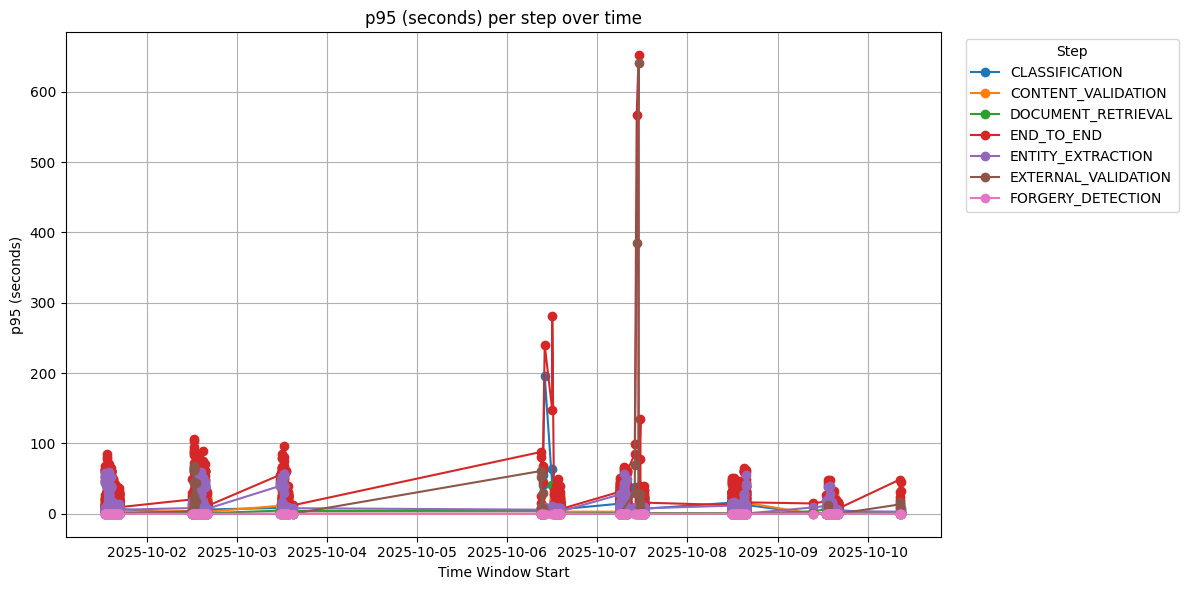

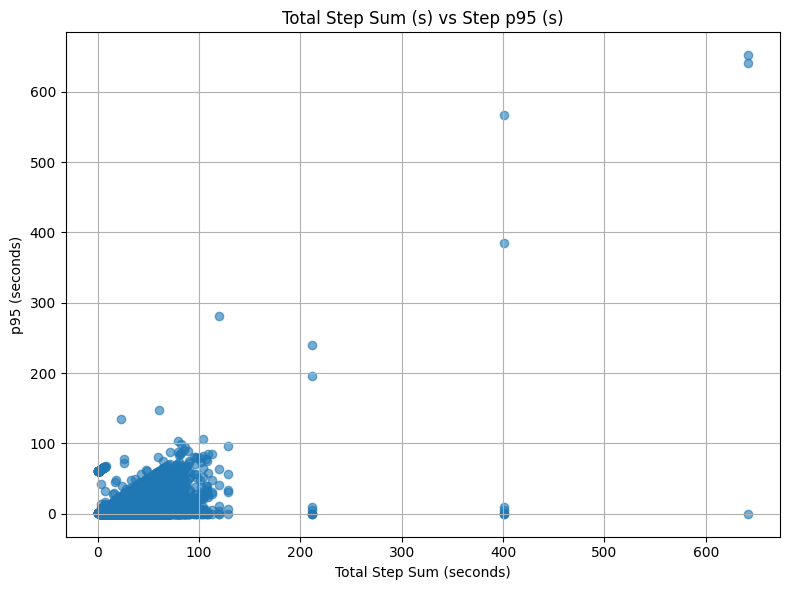

{'rows': 24732,
 'unique_steps': 7,
 'time_coverage_min': Timestamp('2025-10-01 13:00:00'),
 'time_coverage_max': Timestamp('2025-10-10 09:00:00'),
 'nulls_p95_ms': 6295,
 'nulls_total_step_sum_ms': 6}

In [6]:
# Robust Jupyter cell to load, clean, convert ms→seconds, and plot as requested.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# === 1) Load CSV ===
path = "/home/adrian/PycharmProjects/NER-Pipeline/clickhouse.csv"
df = pd.read_csv(path)

# Normalize column names (strip spaces)
df.columns = [c.strip() for c in df.columns]

# Quick peek
display(df.head(50))

# === 2) Coerce numeric columns and parse datetime ===
numeric_cols = ["p95_ms", "median_ms", "total_step_sum_ms", "n"]
for col in numeric_cols:
    if col in df.columns:
        # Remove any non-numeric characters (commas, units, etc.) and coerce to float
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r"[^\d\.\-eE]", "", regex=True), errors="coerce")

# Parse window_start to datetime (be tolerant)
if "window_start" in df.columns:
    # Try parsing as timezone-aware or naive; then make naive for plotting
    parsed = pd.to_datetime(df["window_start"], errors="coerce", utc=True)
    # If everything turned NaT, try without utc
    if parsed.isna().all():
        parsed = pd.to_datetime(df["window_start"], errors="coerce")
    # Drop tz for uniform plotting
    try:
        parsed = parsed.dt.tz_localize(None)
    except Exception:
        # Already naive
        pass
    df["window_start"] = parsed

# Ensure required columns exist
required_cols = ["window_start", "step", "p95_ms", "total_step_sum_ms"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected column(s) in CSV: {missing}. "
                     f"Available columns: {df.columns.tolist()}")

# === 3) Create seconds columns ===
df["p95_s"] = df["p95_ms"] / 1000.0
if "median_ms" in df.columns:
    df["median_s"] = df["median_ms"] / 1000.0
df["total_step_sum_s"] = df["total_step_sum_ms"] / 1000.0

# === 4) Sort for time-series plotting ===
df = df.sort_values(["step", "window_start"])

# === 5) Plot: p95_s for each step over time ===
plt.figure(figsize=(12, 6))
for step, grp in df.groupby("step"):
    # Only plot rows that have both time and p95_s
    g = grp.dropna(subset=["window_start", "p95_s"])
    if g.empty:
        continue
    plt.plot(g["window_start"], g["p95_s"], marker="o", label=str(step))
plt.title("p95 (seconds) per step over time")
plt.xlabel("Time Window Start")
plt.ylabel("p95 (seconds)")
plt.legend(title="Step", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6) Plot: total_step_sum_s vs p95_s (scatter) ===
plt.figure(figsize=(8, 6))
scat = df.dropna(subset=["total_step_sum_s", "p95_s"])
plt.scatter(scat["total_step_sum_s"], scat["p95_s"], alpha=0.6)
plt.title("Total Step Sum (s) vs Step p95 (s)")
plt.xlabel("Total Step Sum (seconds)")
plt.ylabel("p95 (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7) Save a cleaned CSV with seconds included ===
out_path = "/home/adrian/PycharmProjects/NER-Pipeline/clickhouse_cleaned_seconds.csv"
df.to_csv(out_path, index=False)

# Report a small summary back
summary = {
    "rows": len(df),
    "unique_steps": df["step"].nunique(),
    "time_coverage_min": df["window_start"].min(),
    "time_coverage_max": df["window_start"].max(),
    "nulls_p95_ms": int(df["p95_ms"].isna().sum()),
    "nulls_total_step_sum_ms": int(df["total_step_sum_ms"].isna().sum())
}
summary


In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.4 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [7]:
import pandas as pd

df = pd.read_csv("clickhouse_cleaned_seconds.csv")

# Keep only valid rows
df = df.dropna(subset=["window_start", "step", "p95_s", "total_step_sum_s"])

# Aggregate by time window and doc_id
e2e = df[df["step"] == "END_TO_END"][["window_start", "doc_id", "p95_s"]].rename(columns={"p95_s": "end_to_end_s"})
sum_steps = (
    df[df["step"] != "END_TO_END"]
    .groupby(["window_start", "doc_id"], as_index=False)["p95_s"]
    .sum()
    .rename(columns={"p95_s": "sum_components_s"})
)

merged = e2e.merge(sum_steps, on=["window_start", "doc_id"], how="inner")

# Compare
merged["diff_s"] = merged["end_to_end_s"] - merged["sum_components_s"]
merged["diff_pct"] = 100 * merged["diff_s"] / merged["end_to_end_s"]

print(merged.describe()[["end_to_end_s", "sum_components_s", "diff_s", "diff_pct"]])


       end_to_end_s  sum_components_s       diff_s     diff_pct
count   3605.000000       3605.000000  3605.000000  3605.000000
mean      18.456308         20.569095    -2.112787   -16.644584
std       21.425189         21.295977    13.538892    33.118461
min        2.489000          0.481000   -35.643000   -83.059545
25%        8.886000          8.182000    -6.437000   -46.075459
50%       12.873000         15.583000     0.002000     0.019266
75%       20.392000         24.277000     0.004000     0.041540
max      651.861000        641.139000   166.404000    99.204748


In [8]:
import pandas as pd
df = pd.read_csv("clickhouse_cleaned_seconds.csv")

# Keep only END_TO_END rows
e2e = df[df["step"] == "END_TO_END"].copy()

# Compute overall statistics
summary = {
    "count": len(e2e),
    "mean_s": e2e["p95_s"].mean(),
    "median_s": e2e["p95_s"].median(),
    "p95_s": e2e["p95_s"].quantile(0.95),
    "max_s": e2e["p95_s"].max(),
    "under_60_pct": (e2e["p95_s"] <= 60).mean() * 100
}
print(summary)


{'count': 3611, 'mean_s': np.float64(18.528095264469677), 'median_s': np.float64(12.877), 'p95_s': np.float64(58.164500000000004), 'max_s': np.float64(651.861), 'under_60_pct': np.float64(95.12600387704238)}


In [9]:
outliers = e2e[e2e["p95_s"] > 60]
print(f"Outliers: {len(outliers)} ({100*len(outliers)/len(e2e):.2f}%)")
print(outliers[["window_start", "doc_id", "p95_s"]].sort_values("p95_s", ascending=False).head(10))


Outliers: 176 (4.87%)
              window_start                                doc_id    p95_s
12668  2025-10-07 11:00:00  2228ec76-dc91-4655-9e05-cbca9ff3dbd3  651.861
12667  2025-10-07 10:30:00  f30f17d6-74b2-4379-b292-0cf69e7aa3da  567.064
12003  2025-10-06 12:00:00  952db96e-028b-4c1f-87c1-70a37b1fd198  281.299
12001  2025-10-06 10:00:00  96b64c8c-c85f-460c-955d-c9ff04a5aac0  239.846
12002  2025-10-06 12:00:00  8de6b5cd-6304-4b69-ac45-30f20e14f1b9  147.336
12670  2025-10-07 11:30:00  1439f99d-df7a-470a-83f1-40d34dc58009  134.839
11303  2025-10-02 12:30:00  6e12817d-f20f-462c-b707-192ee2c6ee58  105.672
11296  2025-10-02 12:30:00  19fa4623-aa1c-42f9-8324-e10ac9cc671d  103.898
12666  2025-10-07 10:00:00  50ef87df-03c8-4f9a-b7b9-2599bb4528d3   99.648
11720  2025-10-03 12:30:00  49f87fba-d732-4ae8-b0ce-59696668c994   97.029


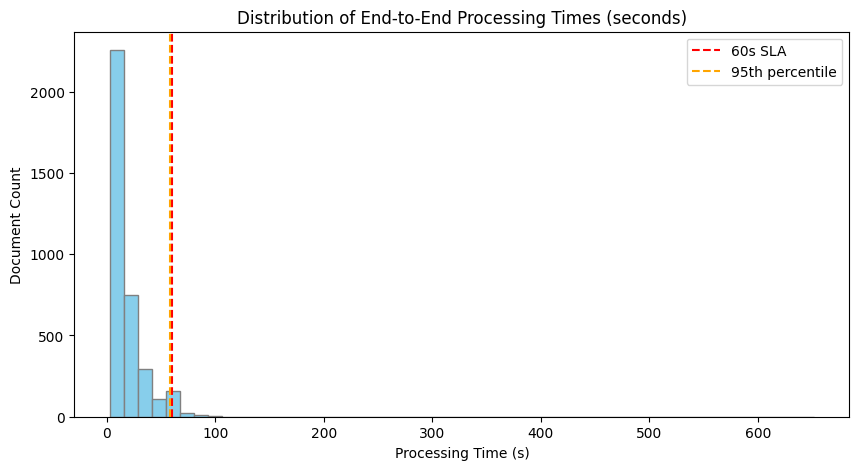

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(e2e["p95_s"], bins=50, color='skyblue', edgecolor='gray')
plt.axvline(60, color='red', linestyle='--', label='60s SLA')
plt.axvline(e2e["p95_s"].quantile(0.95), color='orange', linestyle='--', label='95th percentile')
plt.title("Distribution of End-to-End Processing Times (seconds)")
plt.xlabel("Processing Time (s)")
plt.ylabel("Document Count")
plt.legend()
plt.show()
